# Анализ пользовательского поведения в мобильном приложении

## Оглавление

**Для удобства можете воспользоваться ссылками для перемещения на основные части проекта**

1. [Обзор данных](#start)
2. [Предобработка данных](#preprocessing)

    * [Работа с названиями столбцов](#name)
    * [Обработка пропущенных значений](#null)
    * [Обработка дубликатов](#duplicates)
    * [Работа с типами данных](#type)
    * [Добавление нового столбца](#new_column)
    
    
3. [Исследовательский анализ данных](#data_science)

    * [Количество событий в логе](#events)
    * [Количество пользователей в логе](#user)
    * [События на пользователя](#events-user)
    * [Период данных](#data-time)
    * [Корректность разбиения на группы](#groups)
    

4. [Изучение воронки продаж](#voronka)

    * [События в логах и их частота](#events-col)
    * [Количество пользователей, совершавших событие](#user-per-events)
    * [Воронка](#voronkaind)
    
    
5. [Статистический анализ данных](#stat)

    * [Пользователи в каждой экспериментальной группе](#user-per-group)
    * [А/А-тест](#AA)
    * [Сравнение результатов](#resres)
    
    
6. [Выводы и рекомендации](#recomendation)

## Описание проекта

**Цель исследования:**

Нам необходимо разобраться, как ведут себя пользователи мобильного приложения для продажи продуктов питания.

**В ходе исследования нам предстоит:**

1) Изучить воронку продаж;

2) Исследовать, как пользователи доходят до покупки;

3) Найти количество пользователей, которые доходят до покупки и сколько «застревают» на предыдущих шагах;

4) Определить на каких именно шагах "застревают" пользователи;

5) Исследовать результаты A/A/B-эксперимента для определения лучшего шрифта.

## Описание данных

**Файл /datasets/logs_exp.csv.**

* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


<a id="start"></a>

# Обзор данных

In [1]:
#импорт библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math as mth
from scipy import stats as st
from datetime import datetime, timedelta


In [2]:
#установка цветовой палитры

sns.set_palette('Set2')

In [3]:
#импорт данных

try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
except:
    data = pd.read_csv('logs_exp.csv', sep = '\t')


Ознакомимся с данными

In [4]:
#просмотр первых 5ти строк

data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Исследуем общую информацию

In [5]:
#просмотр основной информации о датасете

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Посмотрим распределение

In [6]:
#просмотр основной информации о датасете

data.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


Теперь перед глазами краткая сводка о наших данных. Можно посмотреть, какие есть колонки, какой тип данных в них содержится и где есть пропуски.

Oбщая гистограмма для всех числовых столбцов таблицы:

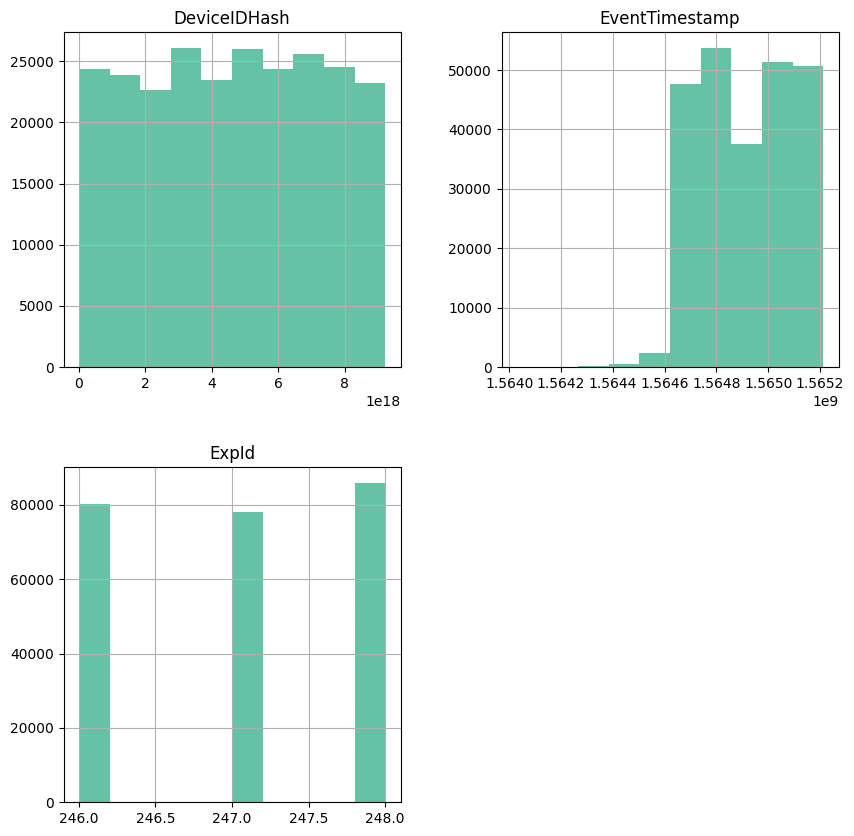

In [7]:
#построение гистограмм для числовых столбцов

data.hist(figsize=(10, 10));

In [8]:
#проверка наличия пропусков

data.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Выводы из первичного анализа данных:

* Всего в файле с данными 244126 строк;
* Следует заменить названия столбцов;
* Есть несоответствия в типах данных;
* Пропуски не обнаружены.

<a id="preprocessing"></a>

# Предобработка данных

Исследуем данные в различных аспектах:

* Названия столбцов
* Пропущенные значения
* Дубликаты и аномалии
* Типы данных

<a id="name"></a>

### Работа с названиями столбцов

Для начала приведем название столбцов к правильному формату

In [9]:
#переименуем некоторые столбцы

data.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'}, inplace=True)

In [10]:
#проверка после переименования

data.head(2)

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


Теперь названия столбцов в правильном формате

<a id="null"></a>

### Обработка пропущенных значений

Проверим наличие пропусков в данных

In [11]:
#проверка наличия пропусков

data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

Пропуски не обнаружены

<a id="type"></a>

### Работа с типами данных

Преобразуем данные в нужные типы

In [12]:
#основная информация о нашем датасете

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Изменим тип данных в data['event_timestamp'] — c object на datetime

In [13]:
#изменение типа данных

data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit = 's')

In [14]:
#проверка данных после изменения типа

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


<a id="duplicates"></a>

### Обработка дубликатов

Проверим данные на наличие дубликатов и аномалий, для этого рассмотрим уникальные значения в данных

In [15]:
#проверка явных дубликатов

data.duplicated().sum()

413

В данных обнаружено 413 явных дубликатов, удалим их.

In [16]:
#удаление явных дубликатов

data.drop_duplicates(inplace = True)
data.reset_index(drop=True, inplace = True)

In [17]:
#проверка явных дубликатов

data.duplicated().sum()

0

Явные дубликаты не обнаружены

Проверим наличие неявных дубликатов и аномалий

In [18]:
#просмотр уникальных значений в столбце 'event_name'

data['event_name'].sort_values().unique()

array(['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial'], dtype=object)

In [19]:
#просмотр уникальных значений в столбце 'device_id_hash'

data['device_id_hash'].sort_values().unique()

array([   6888746892508752,    6909561520679493,    6922444491712477, ...,
       9220879493065341500, 9221926045299980007, 9222603179720523844])

In [20]:
#просмотр уникальных значений в столбце 'event_timestamp'

data['event_timestamp'].min()

Timestamp('2019-07-25 04:43:36')

In [21]:
#просмотр уникальных значений в столбце 'event_timestamp'

data['event_timestamp'].max()

Timestamp('2019-08-07 21:15:17')

In [22]:
#просмотр уникальных значений в столбце 'exp_id'

data['exp_id'].sort_values().unique()

array([246, 247, 248])

Аномалии не обнаружены

<a id="new_column"></a>

### Добавление нового столбца

Для дальнейшей работы добавим новый столбец только с датой 'date'

In [23]:
#создание столбца "date"

data['date'] = pd.to_datetime(data['event_timestamp']).dt.date

In [24]:
#проверка наличия новых столбцов

data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


На данном этапе предобработка данных завершается

В ходе предобработки данных:

* Названия столбцов приведены к правильному формату;
* Проверено наличие пропусков;
* Проверено наличие явных и неявных дубликатов;
* Заменен тип данных в столбце 'event_timestamp';
* Добавлен столбец с датой 'date'.

<a id="data_science"></a>

# Исследовательский анализ данных

<a id="events"></a>

### Количество событий в логе

Для начала посмотрим cколько всего событий в логе

In [25]:
print(format(data['event_name'].count()))

243713


В логе 243 713 событий.

Посмотрим, сколько событий соответствуют каждому типу действий пользователей мобильного приложения:

In [26]:
data['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Чаще всего пользователи открывают главный экран (заглавную страницу) и реже всего открывают обучение, что совсем неудивительно.

<a id="user"></a>

### Количество пользователей в логе

Теперь посмотрим сколько всего пользователей в логе

In [27]:
print(format(data['device_id_hash'].nunique()))

7551


В логе 7 551 пользователь.

<a id="events-user"></a>

### События на пользователя

Посмотрим сколько в среднем событий приходится на пользователя

In [28]:
print(format(round(data['event_name'].count()/data['device_id_hash'].nunique())))

32


В среднем на пользователя приходится 32 события.

Проверим адекватность данной цифры при помощи гистограммы распределения. Построим гистограмму распределения количества событий на пользователя.

In [29]:
event_per_user = data.pivot_table(index = 'device_id_hash', values = 'event_name', aggfunc='count')

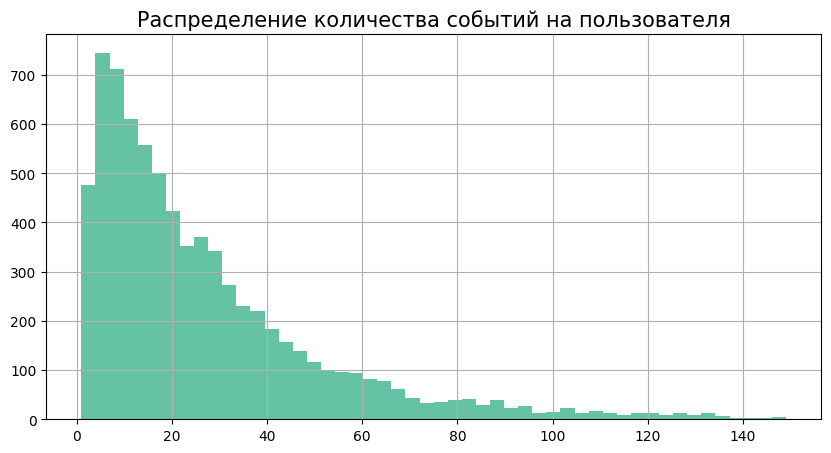

In [30]:
#построение графика распределения количества событий на пользователя

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
event_per_user.query('event_name < 150').hist(bins = 50, ax=ax)
plt.title('Распределение количества событий на пользователя', fontsize=15);

Распределение не нормальное, имеется длинный хвост справа, из-за этого среднее значение сдвинуто вправо. Наибольшее количество заказов приходится на 1-20 событий.

Рассчитаем медианное значение количества событий на пользователя.

In [31]:
data.groupby('device_id_hash')['event_name'].agg('count').median()

20.0

Половине соотвествует количество событий меньше 20, второй половине 20 или больше.

<a id="data-time"></a>

### Период данных

Определим период наших данных. Найдем максимальную и минимальную даты:

In [32]:
print (data['date'].min())
print (data['date'].max())

2019-07-25
2019-08-07


Построим гистограмму по дате и времени:

Возьмем количество бинов - 14 * 24, чтобы каждый бин соответствовал одному часу

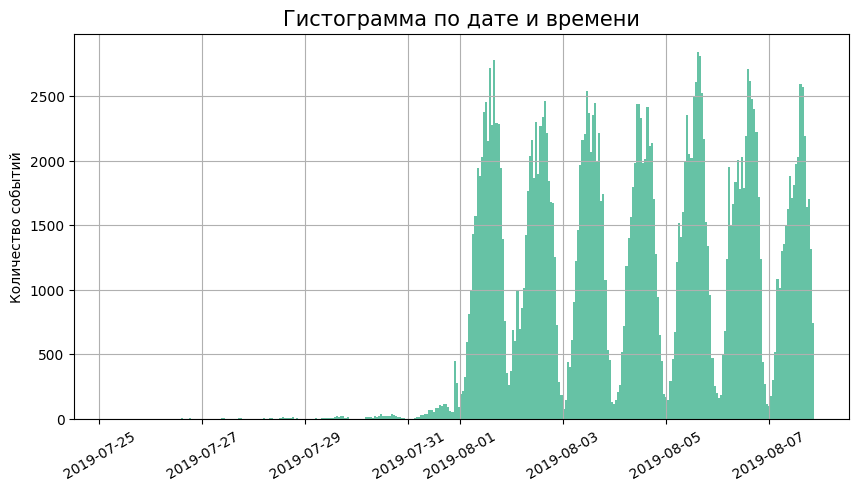

In [33]:
#гистограмма по дате и времени

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
data['event_timestamp'].hist(bins = 14*24, ax=ax)
plt.xticks(rotation = 30)
plt.ylabel('Количество событий')
plt.title('Гистограмма по дате и времени', fontsize=15);

Основная часть данных приходится на 01-08-2019 - 08-08-2019. Данных до 1го августа очень мало, скорее всего это события, которые "доехали" из прошлого, они могут негативно влиять на данные, "перекашивая" их. Найдем, какую долю они составляют от общего числа, чтобы понять можно ли их отсечь.

Посмотрим на количество таких данных:

In [34]:
#количество событий, которые относятся к "старым данным"

date_to_cut = pd.to_datetime("2019-8-1").date()
data.query('date < @date_to_cut')['event_name'].count()

2826

Количество событий, которые приходятся на даты раньше 1 августа 2019 - 2826, это чуть больше 1% от всех данных. Приемлемое количество для удаления. Отбросим данные за этот период.

Посмотрим, сколько пользователей относятся к этим данным

In [35]:
#количество пользователей, которые относятся к старым данным

data['device_id_hash'].nunique() - data.query('date >= @date_to_cut')['device_id_hash'].nunique()

17

Посмотрим, какую долю составляют пользователи относящиеся к данным до 1 августа

In [36]:
#доля пользователей старых данных относительно всех

round((data['device_id_hash'].nunique() - data.query('date >= @date_to_cut')['device_id_hash'].nunique()) / data['device_id_hash'].nunique(), 4)

0.0023

Итог:
- Количество событий, которые приходятся на даты раньше 1 августа 2019 - 2826, это чуть больше 1% от всех данных;
- Количество пользователей, которые относятся этим событиям - 17, это всего 0,23% от общего числа всех пользователей;

=> Данные за этот период можно и нужно удалить, потеря такого количества информации не скажется негативно на нашем исследовании

In [37]:
data = data.query('date >= @date_to_cut')

Определим реальный период наших данных. Найдем максимальную и минимальную даты:

In [38]:
print (data['date'].min())
print (data['date'].max())

2019-08-01
2019-08-07


<a id="groups"></a>

### Корректность разбиения на группы

Посмотрим, сколько пользователей в каждой экспериментальной группе

In [39]:
data.groupby('exp_id').agg({'device_id_hash' : 'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


Во все три группы входит примерно одинаковые количество пользователей

Посмотрим процент пользователей, которые входят в обе группы

In [40]:
round(((data[['device_id_hash', 'exp_id']].drop_duplicates().drop(columns='exp_id').duplicated().sum())/data['device_id_hash'].nunique())*100, 2)

0.0

Отлично, таких пользователей нет!

Количество пользователей в группах приблизительно одинаковое, пользователи, состоящие в сразу нескольких группах, отсутсвуют, следовательно, разбиение на группы работает корректно.

**Выводы исследовательского анализа данных:**

- Всего в логе 243 713 событий;
- Чаще всего пользователи открывают главный экран и реже всего открывают обучение;
- Всего в логе 7 551 пользователь;
- В среднем на пользователя приходится 32 события;
- Распределение не нормальное, имеется длинный хвост справа, медиана 20;
- Наибольшее количество заказов приходится на 1-20 событий;
- Количество событий, которые приходятся на даты раньше 1 августа 2019 чуть больше 1%;
- Реальный период наших данных (после очистки) - c 2019-08-01 по 2019-08-07;
- Пользователи, входящие в обе группы, отсутствуют;
- Количество пользователей в группах приблизительно одинаковое;
- Разбиение на группы работает корректно..

<a id="voronka"></a>

# Изучение воронки продаж

<a id="events-col"></a>

### События в логах и их частота

Для начала посмотрим какие события есть в логах и как часто они встречаются

In [41]:
data['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

In [42]:
#количество раз, когда каждое из событий встречается в логах

data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

В данных содержится информация о следующих действиях пользователей мобильного приложения:

- Появление главного экрана;
- Появление экрана предложений;
- Появление экрана корзины;
- Появления экрана с успешной оплатой;
- Обучение.

Чаще всего пользователи открывают главный экран (заглавную страницу) и реже всего открывают обучение, что совсем неудивительно.

<a id="user-per-events"></a>

### Количество пользователей, совершавших событие

Посчитаем сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие

In [43]:
event_stat = data.groupby('event_name').agg({'device_id_hash' : 'nunique'}).sort_values(by = 'device_id_hash', ascending = False)
event_stat['percentage'] = round(event_stat['device_id_hash'] / data['device_id_hash'].nunique() * 100, 1)
event_stat

,device_id_hash,percentage
event_name,,
MainScreenAppear,7419,98.5
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.6
PaymentScreenSuccessful,3539,47.0
Tutorial,840,11.1


Выводы:
- Чуть больше 98% пользователей открывали главный экран;
- 61% пользователей переходили на экран предложений;
- Почти 50% пользователей открывали корзину;
- 47% пользователей оплачивали заказ;
- Только 11% пользователей переходили на обучение.

<a id="voronkaind"></a>

### Воронка

Посмотрим в каком порядке происходят события

Порядок событий:

1) Появление главного экрана;

2) Появление экрана предложений;

3) Появление экрана корзины;

4) Появления экрана с успешной оплатой.

Прохождение обучения не входит в цепочку действий пользователей приложения для совершения покупки, поэтому при расчете воронки событий "Обучение" учитывать не будем.

Исключим обучение:

In [44]:
#исключение обучения из таблицы

event_stat.drop('Tutorial', axis = 0, inplace = True)

Посчитаем какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [45]:
event_stat['conversion'] = round(event_stat['device_id_hash'] / event_stat['device_id_hash'].shift(fill_value=0) * 100, 1)
event_stat

,device_id_hash,percentage,conversion
event_name,,,
MainScreenAppear,7419,98.5,inf
OffersScreenAppear,4593,61.0,61.9
CartScreenAppear,3734,49.6,81.3
PaymentScreenSuccessful,3539,47.0,94.8


Больше всего пользователей теряется при переходе с главного экрана на экран предложений.

Выводы:
- С главного экрана на экран предложений переходит почти 62% пользователей;
- С экрана предложений на экран корзины переходит чуть больше 81% пользователей;
- С экрана корзины на экран успешной оплаты переходит почти 95% пользователей.

Посмотрим какая доля пользователей доходит от первого события до оплаты

In [46]:
print('От первого события до оплаты доходят {0}% пользователей'.format(round(event_stat['device_id_hash'][3] / event_stat['device_id_hash'][0] * 100)))

От первого события до оплаты доходят 48% пользователей


Добавим визуализацию воронки

In [47]:
#визуализация воронки событий

import plotly.express as px
data_plot = dict(
    number=event_stat['device_id_hash'],
    stage=["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"])
fig = px.funnel(data_plot, x='number', y='stage')
fig.show()

<a id="stat"></a>

# Статистический анализ данных

<a id="user-per-group"></a>

### Пользователи в каждой экспериментальной группе

Посмотрим сколько пользователей в каждой экспериментальной группе

In [48]:
data.groupby('exp_id').agg({'device_id_hash' : 'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


- В группе 246 находится 2484 пользователя;
- В группе 247 находится 2513 пользователей;
- В группе 248 находится 2537 пользователй.

<a id="AA"></a>

### А/А-тест

У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов, нужно посмотреть находят ли статистические критерии разницу между выборками 246 и 247

Посчитаем количество пользователей в группе

In [49]:
event_test = data.pivot_table(index = 'event_name', columns = 'exp_id', values = 'device_id_hash', aggfunc = 'nunique')
event_test['combined'] = event_test[246] + event_test[247]
event_test.drop('Tutorial', axis = 0, inplace=True)
event_test

exp_id,246,247,248,combined
event_name,,,,
CartScreenAppear,1266,1238,1230,2504
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
PaymentScreenSuccessful,1200,1158,1181,2358


Посчитайте долю пользователей, совершивших событие. Проверим, будет ли отличие между группами статистически достоверным.

Сформулируем гипотезы:

Н0: Доли пользователей по событиям в воронке одинаковы.

Н1: Есть различие между долями пользователей по событиям в воронке.

alpha = 0.05

In [50]:
groups = data.groupby('exp_id')['device_id_hash'].agg('nunique')

In [51]:
#функция для z-теста

def for_test(successes, trials, alpha):
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1-p_combined)*(1/trials[0] + 1/trials[1]))


    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

In [52]:
#функция для тестирования
def test(group1, group2, alpha):

    trials = ([groups[group1], groups[group2]])

    Main = ([event_test.query('event_name == "MainScreenAppear"')[group1],
             event_test.query('event_name == "MainScreenAppear"')[group2]])

    Offers = ([event_test.query('event_name == "OffersScreenAppear"')[group1],
               event_test.query('event_name == "OffersScreenAppear"')[group2]])

    Cart = ([event_test.query('event_name == "CartScreenAppear"')[group1],
             event_test.query('event_name == "CartScreenAppear"')[group2]])

    Payment = ([event_test.query('event_name == "PaymentScreenSuccessful"')[group1],
                event_test.query('event_name == "PaymentScreenSuccessful"')[group2]])

    print('Гипотеза о равенстве долей для групп, событие - появление главного экрана:')
    for_test(Main, trials, alpha)

    print('Гипотеза о равенстве долей для групп, событие - появление экрана предложений:')
    for_test(Offers, trials, alpha)

    print('Гипотеза о равенстве долей для групп, событие - появление экрана корзины:')
    for_test(Cart, trials, alpha)

    print('Гипотеза о равенстве долей для групп, событие - появление экрана успешной оплаты:')
    for_test(Payment, trials, alpha)

Проведем сравнение двух контрольных групп

In [53]:
test(246, 247, 0.05)

Гипотеза о равенстве долей для групп, событие - появление главного экрана:
p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана предложений:
p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана корзины:
p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана успешной оплаты:
p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу


Отличия между двумя группами по всем четырем событиям не обнаружены => разбиение на группы работает корректно.

<a id="resres"></a>

### Сравнение результатов

Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой

Группа 246 с экспериментальной:

In [54]:
test(246, 248, 0.05)

Гипотеза о равенстве долей для групп, событие - появление главного экрана:
p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана предложений:
p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана корзины:
p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана успешной оплаты:
p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу


Группа 247 с экспериментальной:

In [55]:
test(247, 248, 0.05)

Гипотеза о равенстве долей для групп, событие - появление главного экрана:
p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана предложений:
p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана корзины:
p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана успешной оплаты:
p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу


Экспериментальная группа с объединенной контрольной

In [56]:
groups['combined'] = groups[246] + groups[247]

In [ ]:
test('combined', 248, 0.05)

Гипотеза о равенстве долей для групп, событие - появление главного экрана:
p-значение:  [0.29424527]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана предложений:
p-значение:  [0.4342555]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана корзины:
p-значение:  [0.18175875]
Не получилось отвергнуть нулевую гипотезу
Гипотеза о равенстве долей для групп, событие - появление экрана успешной оплаты:
p-значение:  [0.60042943]
Не получилось отвергнуть нулевую гипотезу


Отличия между двумя группами по всем четырем событиям не обнаружены => разбиение на группы работает корректно.

Мы выбрали уровень значимости 0,05. При этом уровне значимости все нулевые гипотезы не были отвергнуты. При увеличении уровня статистической значимости растет вероятность ошибки первого рода. При уровне значимости 0,1 каждый десятый раз можно получать ошибочный результат. В нашем исследовании уровень 0,05 можно считать оптимальным, т.к. вероятность получить ложный результат 1 к 20. Учитывая, что у нас 16 проверок гипотез, этого достаточно.

**Выводы из результатов эксперимента:**

1) Между:

     - контрольными группами;
     - контрольной группой 246 и экспериментальной;
     - контрольной группой 247 и экспериментальной;
     - объединенной контрольной группой и экспериментальной.
   
    нет статистически значимых различий между долями пользователей, совершивших событие.

2) Изменение шрифта не отразилось на поведении пользователей.

<a id="recomendation"></a>

# Общий вывод

- В ходе анализа стартапа по продаже продуктов питания был опреден период времени: с 1 по 7 августа 2019 года. Все старые данные были отброшены. Потеряно было 1,16% от всех событий и 0,23% от всех пользователей, что является допустимым;
- Количество пользователей в группах приблизительно одинаковое;
- Воронка событий для пользователей имеет следующий вид:

    1. Появление главного экрана - 98,5% пользователей;
    2. Появление экрана предложений - 61% пользователей;
    3. Появление экрана корзины - 49,6% пользователей;
    4. Появление экрана успещной оплаты - 47% пользователей.
    
    
- Больше всего пользователей теряется на втором шаге - переход на экран предложений;
- При анализе А/А/В-тестов статистически значимые различия между долями пользователей, совершивших событие, не были выявлены (при уровне значимости, равном 0,05). Изменение шрифтов не оказало влияния на поведение пользователя.